In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scripts.dataset_explorer import SODataSetExplorer
from scripts.tech_labeling import tech_labeling 

In [2]:
import plotly.express as px
import plotly
import plotly.io as pio
import plotly.graph_objects as go

In [3]:
import chart_studio
import chart_studio.plotly as py
import os

chart_studio_apikey = os.getenv('CHART_STUDIO_API_KEY')
chart_studio.tools.set_credentials_file(username='masharo', api_key=chart_studio_apikey)

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Load Dataset

In [5]:
df_explorer = SODataSetExplorer()

### Exploring Programming languages

In [6]:
df_explorer.similar_columns(['language', 'tech',]);

2011
{'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year'}


2012
{'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year'}


2013
{'importance_opportunity_to_use_learn_new_technologies',
 'new_tech_interests',
 'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'techn_related_purchases_last_year',
 'time_per_week_technical_support'}


2014
{'new_tech_interests',
 'programming_languages',
 'programming_languages_other',
 'tech_products_own',
 'tech_products_own_other',
 'time_per_week_technical_support'}


2015
{'programming_languages',
 'programming_languages_other',
 'want_work_language',
 'want_work_language_other'}


2016
{'agree_tech',
 'important_newtech',
 'tech_do',
 'tech_want',
 'why_learn_new_tech'}


2017
{'assess_job_tech',
 'have_worked_la

* Rename feature into `programming_languages`

In [7]:
progr_lang_rename = {
    'tech_do': 'programming_languages',
    'have_worked_language': 'programming_languages',
    'language_worked_with': 'programming_languages',
}
df_explorer.rename_columns(progr_lang_rename)

* `programming_languages`. Multiple choice categorical features

* Merging feature `programming_languages` feature across years 

### Handling programming languages

In [8]:
lang_df = df_explorer.get_feature_dummies_per_year('programming_languages', remove_white_spaces=True)

In [9]:
n_largest = 10
lang_per_year = {}
for year, lang in lang_df.items():
    # calculating percentage of total users
    lang_percentage = (lang.sum() / lang.shape[0]).reset_index()
    lang_percentage.columns = ['language', 'percentage']
    lang_percentage['year'] = year
    # filtering by programming language tech type
    lang_percentage['tech_type'] = lang_percentage.language.map(lambda x: tech_labeling.get(x.lower(), ''))
    lang_percentage = lang_percentage[lang_percentage.tech_type.isin(['language'])][['year', 'language', 'percentage']]
    # top programming languages
    lang_percentage = lang_percentage.nlargest(n=n_largest,columns=['percentage'])
    # sorting values
    lang_percentage = lang_percentage.sort_values(by=['percentage']).reset_index(drop=True)
    # save finally df
    lang_per_year[year] = lang_percentage

In [10]:
lang_per_year[2020]

,year,language,percentage
0,2020,C,0.193714
1,2020,C++,0.212640
2,2020,TypeScript,0.226152
3,2020,PHP,0.232807
4,2020,C#,0.279875
5,2020,Java,0.357953
6,2020,Python,0.392284
7,2020,SQL,0.487318
8,2020,HTML/CSS,0.561285
9,2020,JavaScript,0.602256


In [11]:
lang_per_year[2020].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10 non-null     int64  
 1   language    10 non-null     object 
 2   percentage  10 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 368.0+ bytes


### Viz - Common languages evolution

In [12]:
concat_programming_languages = pd.concat(lang_per_year.values(), ignore_index=True)

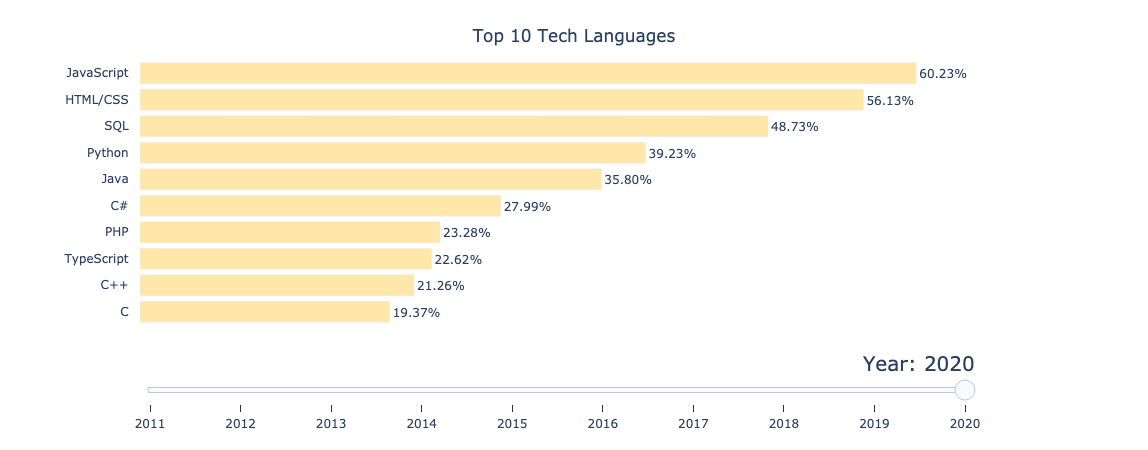

In [63]:
fig = px.bar(
    concat_programming_languages, x="percentage", y="language", text="percentage",
    animation_frame="year", 
    color_discrete_sequence=['rgb(255, 231, 169)'],
    hover_data={'year': False, 'language': True, 'percentage':':.2%',},
)
        
slider_duration = 400
for step in range(len(fig.layout.sliders[0].steps)):
    fig.layout.sliders[0].steps[step].args[1]['transition'] = {"duration": slider_duration, "easing": "cubic-in-out"}
    fig.layout.sliders[0].steps[step].args[1]['frame'] = {'duration': slider_duration, 'redraw': True}

# button_duration = 1000
# fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = button_duration
# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = button_duration
fig.layout.updatemenus[0].buttons = None
fig.layout.sliders[0]['x'] = 0
fig.layout.sliders[0]['y'] = 0.15
fig.layout.sliders[0]['currentvalue'] = {
    "font": {"size": 20},
    "prefix": "Year: ",
    "visible": True,
    "xanchor": "right"
}

textposition='outside'
hovertemplate = "%{y}: %{x:.2%}<br>"+"<extra></extra>"
for frame in fig.frames:
    frame.data[0]['hovertemplate'] = hovertemplate
    frame.data[0]['textposition'] = textposition

# changing default active plot 
last_frame_index = len(fig.layout.sliders[0].steps) - 1
fig.layout.sliders[0]['active'] = last_frame_index
fig.data = None
fig.add_trace(fig.frames[last_frame_index].data[0])

fig.update_layout(
    showlegend=False,
    xaxis=dict(
        showgrid=False,
        showline=False,
        zeroline=False,
        showticklabels=False,
        title='',
        range=[0, 0.72]
    ),
    yaxis=dict(
        title='',
        showgrid=False,
        showline=False,
        zeroline=False,
        ticks= "outside", 
        tickcolor= 'white', 
        ticklen= 8,
    ),
    title=dict(
        text= "Top 10 Tech Languages",
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin= {'l': 140},
)

fig.update_traces(
    texttemplate='%{text:.2%}',
    textposition=textposition,
    hovertemplate = hovertemplate
)

fig.show()

In [61]:
py.plot(fig, filename = 'stack-overflow-languages-over-year')

'https://plotly.com/~masharo/56/'